ValueError: x and y must have same first dimension, but have shapes (3600,) and (1,)

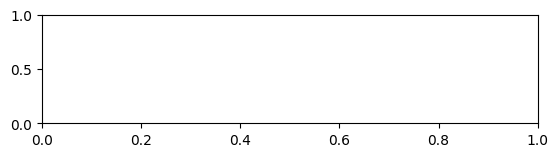

In [ ]:
## Simulação do modelo, de circuito elétrico, da bateria

import numpy as np
import matplotlib.pyplot as plt

#########################################################################

# Parametros
R1 = 0.009818
R2 = 0.031463
C1 = 15639.0
C2 = 39332.0

Q_bat = 3.08 * 3600  # Capacidade em A*s = Coulombs

# Matrizes
A = np.array([[-1/(R1*C1), 0, 0],[0, -1/(R2*C2), 0],[0, 0, 0]])

B = np.array([[1/C1],[1/C2],[-1/Q_bat]])

# Estado Inicial x0 (v1=0, v2=0, SOC=100%)
x = np.array([[0.0], [0.0], [1.0]])

# Polinômios para cálculo de Voc e R0
alpha_coeffs = np.array([0.140437, -0.693293, 1.448317, -1.665299, 1.148704, 
                         -0.486836, 0.125421, -0.01891, 0.001657, 0.000269]) * 1e4

beta_coeffs  = np.array([0.440568, -2.188575, 4.662025, -5.561277, 4.069003, 
                         -1.878727, 0.541296, -0.092097, 0.008056, -0.000161]) * 1e3


#########################################################################

# Configuração da Simulação
dt = 1.0               # Passo de tempo (1 segundo)
t_total = 3600         # Tempo total (1 hora)
time = np.arange(0, t_total, dt) # Vetor de tempo
steps = len(time)

# Perfil de entrada [u]
u_profile = np.full(steps, 2) # Descarga de xAmperes durante todo o tempo (time)

# Estado Inicial x0 (v1=0, v2=0, SOC=100%)
x = np.array([[0.0], [0.0], [1.0]])

# Listas para guardar o histórico
y_history = []    # Tensão terminal (Saída)
soc_history = []  # SOC (Estado)


#########################################################################

## Calculo de Voc
def get_Voc(xsoc, alpha):
    """ 
    Calcula a tensão de circuito aberto Voc dado os parâmetros alfa e o atual estado xsoc
    """
    # Inicializa com voc = 0 V
    voc = 0.0
    for n, alpha in enumerate(alpha):
            voc += alpha * (xsoc ** n)
            
    return voc

## Calculo de R0
def get_R0(xsoc, beta):
    """ 
    Calcula a Resistencia R0 dado os parâmetros Beta e o atual estado xsoc
    """
    # Inicializa com R0 = 0 V
    R0 = 0.0
    for n, beta in enumerate(beta):
            R0 += beta * (xsoc ** n)
            
    return R0

#########################################################################
""" Alguns testes
soc_atual = 1
voc_calculado = get_Voc(soc_atual, alpha_coeffs)
R0_calculado = get_R0(soc_atual, beta_coeffs)


print(f"Para SOC {soc_atual}, o Voc é {voc_calculado:.4f} V")
print(f"Para SOC {soc_atual}, o R0 é {R0_calculado:.4f} ohms")
"""

#########################################################################

# Loop principal
for n in range(steps):

    x_dot = A @ x + B * u_profile

    # Atualizando x
    x = x + x_dot * dt

    # Extrair os dados dos vetores
    v1 = x[0,0]
    v2 = x[1,0]
    soc = x[2,0]

    # Calcular o Y
    voc = get_Voc(soc, alpha_coeffs)
    R0 = get_R0(soc, beta_coeffs)

    y = voc - v1 - v2 - (R0 * u_profile)

    soc_history.append(soc)
    y_history.append(soc)


    #print(f"{soc}-")

#############################################################

## Plotagem dos Gráficos
# Gráfico 1: Entrada (Corrente)
plt.subplot(3, 1, 1)
plt.plot(time, u_profile, color='blue')
plt.title('Entrada u(t): Corrente')
plt.ylabel('Amperes (A)')
plt.grid(True)

# Gráfico 2: Saída (Tensão)
plt.subplot(3, 1, 2)
plt.plot(time, y_history, color='red')
plt.title('Saída y(t): Tensão nos Terminais')
plt.ylabel('Volts (V)')
plt.grid(True)

# Gráfico 3: Estado Interno (SOC)
plt.subplot(3, 1, 3)
plt.plot(time, np.array(soc_history)*100, color='green')
plt.title('Estado x3(t): Nível de Carga (SOC)')
plt.ylabel('SOC (%)')
plt.xlabel('Tempo (segundos)')
plt.grid(True)

plt.tight_layout()
plt.show()
      